In [12]:
import itertools

import matplotlib.pyplot as plt
import pandas as pd
import pyprojroot
import scipy.stats
import sklearn.linear_model

import seaborn as sns

In [2]:
searchstims_csv = pyprojroot.here('results/searchstims/source_data/3stims/all.csv')
vsd_csv = pyprojroot.here('results/VSD/source_data/VSD-searchstims-all.csv')

In [3]:
searchstims_df = pd.read_csv(searchstims_csv)

In [4]:
searchstims_df = searchstims_df[
    (searchstims_df.method == 'transfer') & 
    (searchstims_df.target_condition == 'both')
]
searchstims_df['accuracy'] = searchstims_df['accuracy'] * 100
searchstims_df = searchstims_df[
    ['method', 'net_name', 'net_number', 'stimulus', 'target_condition',
     'set_size', 'n_correct', 'n_trials', 'accuracy']
]
searchstims_df['Adapted to'] = 'Simplified stimuli'

In [7]:
vsd_df = pd.read_csv(vsd_csv)
vsd_df = vsd_df[
    ['method', 'net_name', 'net_number', 'stimulus', 'target_condition',
     'set_size', 'n_correct', 'n_trials', 'accuracy']
]
vsd_df['Adapted to'] = 'Natural images'

In [8]:
df_all = pd.concat((searchstims_df, vsd_df))

In [9]:
records = []

for adapt_dataset in df_all['Adapted to'].unique():
    df_adapt = df_all[df_all['Adapted to'] == adapt_dataset]
    
    net_names = df_adapt.net_name.unique().tolist()
    stimuli = df_adapt.stimulus.unique().tolist()
    train_replicates = df_adapt.net_number.unique().tolist()
    
    to_do = list(
        itertools.product(net_names, stimuli, train_replicates)
    )
    
    for net_name, stimulus, replicate_num in to_do:
        this_df = df_adapt[
            (df_adapt.net_name == net_name) &
            (df_adapt.stimulus == stimulus) &
            (df_adapt.net_number == replicate_num)
        ]
        x = this_df.set_size.values.reshape(-1, 1)
        y = this_df.accuracy.values
        
        reg = sklearn.linear_model.LinearRegression().fit(x, y)
        
        records.append(
            {
                'Adapted to': adapt_dataset,
                'net_name': net_name,
                'stimulus': stimulus,
                'replicate_num': replicate_num,
                'Slope': reg.coef_.item(),
                'Intercept': reg.intercept_,
            }
        )

In [10]:
df_fits = pd.DataFrame.from_records(records)

In [24]:
FIGURES_ROOT = pyprojroot.here('docs/paper/figures/experiment-2')

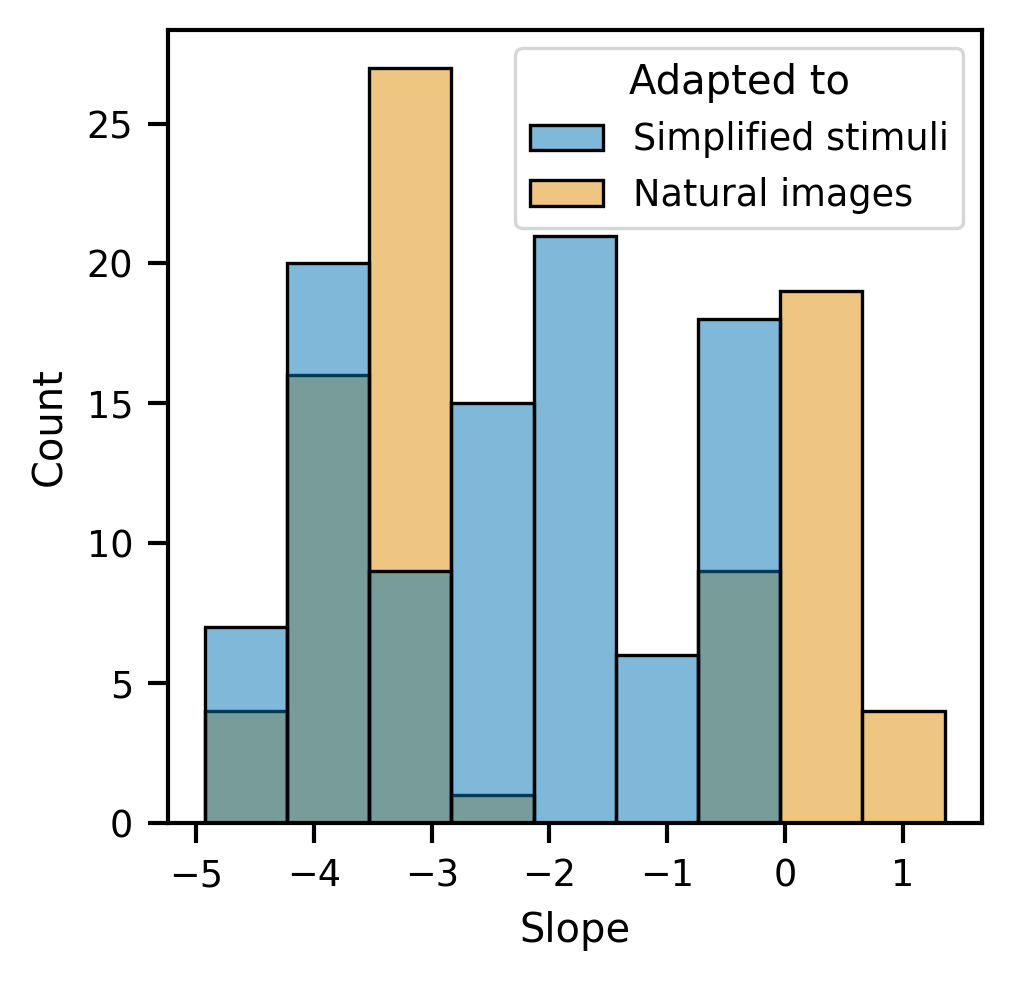

In [25]:
sns.set_context('paper')
sns.set_palette('colorblind')

fig, ax = plt.subplots(figsize=(3.5, 3.5), dpi=300)

sns.histplot(
    data=df_fits,
    x='Slope',
    hue='Adapted to',
    ax=ax
)

for ext in ('svg', 'png'):
    fig_path = FIGURES_ROOT.joinpath(
        f'searchstims-v-VOC-slope.{ext}'
    )
    plt.savefig(fig_path, bbox_inches="tight")

In [28]:
x = df_fits[df_fits['Adapted to'] == 'Simplified stimuli'].Slope.values
y = df_fits[df_fits['Adapted to'] == 'Natural images'].Slope.values
scipy.stats.mannwhitneyu(x, y)

MannwhitneyuResult(statistic=3488.0, pvalue=0.29631922467873484)